In [10]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy
import time


### Detector Geometry

In [11]:
N_MODULES = 3
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX]*N_MODULES,
    ly=[LY]*N_MODULES,
    z=[i+Z_SPACING for i in range(N_MODULES)]
)

detector

SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0])

### Particle Generator


In [12]:
generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi/6
)
generator

SimpleGenerator(detector_geometry=SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0]), primary_vertices=[], phi_min=0.0, phi_max=6.283185307179586, theta_min=0.0, theta_max=0.5235987755982988, rng=Generator(PCG64) at 0x29A0AA2B760)

In [13]:
N_PARTICLES = 3
event = generator.generate_event(N_PARTICLES)
event.hits

[Hit(hit_id=0, x=0.014879857611754681, y=-0.13771169648223258, z=1.0, module_id=0, track_id=0),
 Hit(hit_id=3, x=-0.2976060410238731, y=-0.1261824399495064, z=1.0, module_id=0, track_id=1),
 Hit(hit_id=6, x=0.16419216937661196, y=-0.22773079430631632, z=1.0, module_id=0, track_id=2),
 Hit(hit_id=1, x=0.029759715223509363, y=-0.27542339296446516, z=2.0, module_id=1, track_id=0),
 Hit(hit_id=4, x=-0.5952120820477462, y=-0.2523648798990128, z=2.0, module_id=1, track_id=1),
 Hit(hit_id=7, x=0.3283843387532239, y=-0.45546158861263264, z=2.0, module_id=1, track_id=2),
 Hit(hit_id=2, x=0.04463957283526405, y=-0.41313508944669775, z=3.0, module_id=2, track_id=0),
 Hit(hit_id=5, x=-0.8928181230716192, y=-0.3785473198485192, z=3.0, module_id=2, track_id=1),
 Hit(hit_id=8, x=0.492576508129836, y=-0.6831923829189491, z=3.0, module_id=2, track_id=2)]

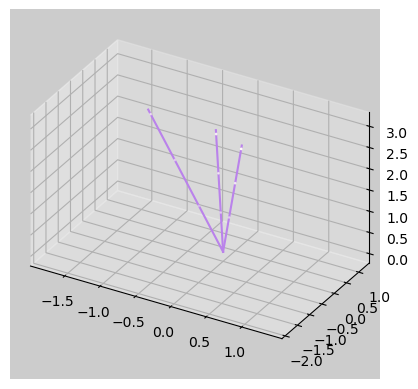

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
event.display(ax)
plt.show()

In [15]:
def generate_hamiltonian(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = copy.deepcopy(event.modules)
    modules.sort(key=lambda a: a.z)

    segments = [em.segment(from_hit, to_hit) for idx in range(len(modules) - 1) for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)]
    print(segments)
    N = len(segments)
    A = np.zeros((N, N))
    A_ang = np.zeros((N, N))
    A_bif = np.zeros((N, N))
    
    b = np.zeros(N)

    s_ab = np.zeros((N, N))
    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            s_ab[i, j] = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
    A_inh = np.zeros((N, N))

    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            if i != j:
                vect_i = seg_i.to_vect()
                vect_j = seg_j.to_vect()
                cosine = np.dot(vect_i, vect_j) / (np.linalg.norm(vect_i) * np.linalg.norm(vect_j))

                eps = 1e-9

                if np.abs(cosine - 1) < eps:
                    A_ang[i, j] = 1

                if (seg_i.from_hit == seg_j.from_hit) and (seg_i.to_hit != seg_j.to_hit):
                    A_bif[i, j] = -alpha

                if (seg_i.from_hit != seg_j.from_hit) and (seg_i.to_hit == seg_j.to_hit):
                    A_bif[i, j] = -alpha

                A_inh[i, j] = s_ab[i, j] * s_ab[j, i] * beta

    # Compute the final expression
    A = -1 * (A_ang + A_bif + A_inh)

    components = {'A_ang': -A_ang, 'A_bif': -A_bif, 'A_inh': -A_inh}

    return A, b, components, segments

params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,} 
start_time = time.time()
A, b, _, _ = generate_hamiltonian(event, params)
finish_time = time.time()
print(A)
print(f'{finish_time - start_time}s')

[segment(from_hit=Hit(hit_id=0, x=0.014879857611754681, y=-0.13771169648223258, z=1.0, module_id=0, track_id=0), to_hit=Hit(hit_id=1, x=0.029759715223509363, y=-0.27542339296446516, z=2.0, module_id=1, track_id=0), truth=True), segment(from_hit=Hit(hit_id=0, x=0.014879857611754681, y=-0.13771169648223258, z=1.0, module_id=0, track_id=0), to_hit=Hit(hit_id=4, x=-0.5952120820477462, y=-0.2523648798990128, z=2.0, module_id=1, track_id=1), truth=False), segment(from_hit=Hit(hit_id=0, x=0.014879857611754681, y=-0.13771169648223258, z=1.0, module_id=0, track_id=0), to_hit=Hit(hit_id=7, x=0.3283843387532239, y=-0.45546158861263264, z=2.0, module_id=1, track_id=2), truth=False), segment(from_hit=Hit(hit_id=3, x=-0.2976060410238731, y=-0.1261824399495064, z=1.0, module_id=0, track_id=1), to_hit=Hit(hit_id=1, x=0.029759715223509363, y=-0.27542339296446516, z=2.0, module_id=1, track_id=0), truth=False), segment(from_hit=Hit(hit_id=3, x=-0.2976060410238731, y=-0.1261824399495064, z=1.0, module_id=

In [16]:
from dwave.samplers import SimulatedAnnealingSampler
import dimod
import dimod.binary

In [28]:
str_time = time.time()
matrix_A = np.array(A)
bqm = dimod.BinaryQuadraticModel(b, A, 0.0, dimod.BINARY)
q, off = bqm.to_qubo()


sampler = SimulatedAnnealingSampler()
response = sampler.sample_qubo(q, num_reads=100)
best_sample = response.first.sample
sol_sample= np.array(list(best_sample.values()))
end_time = time.time()
print(sol_sample)
print(f'{end_time-str_time}')

[1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1]
0.06742382049560547


[1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1]
Execution time: 0.1200 seconds
